# Prédiction du nombre d'antennes susceptibles d'etre installées dans l'avenir (prédictions sur 1 ans, en général et pour les principaux opérateurs (SFR, Orange, Bouygues, Free)

In [405]:
#Installation des libraries et modules nécessaires pour les prédictions
!pip install tensorflow
!pip install keras
!pip install psycopg2
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [406]:
#Connexion à la base de données cible: PostgreSQL
try:
    #création d'une connexion à la BD postegre en 
    #spécifiant les paramètres de connexion
    conn = psycopg2.connect(
        host="localhost",
        database="observatoireFrance",
        user="user",
        password="monpass")

    #gestion des erreurs de connexion
except psycopg2.Error as e:
    #si la connexion échoue, afficher l'erreur
    print("Error connecting to the database:")
    print(e)
    #sinon, afficher la ligne suivante
else:
    print("Connection established successfully")

Connection established successfully


#### Extraction des données de la base de données dans un dataframe (librairie Pandas)

In [407]:
#Extraction des données de la BD postegres dans un dataframe en utilisation la librairie Pandas et la connexion créee
df = pd.read_sql_query('select * from public."observatoireCible5G"',con=conn)

C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3280364248.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select * from public."observatoireCible5G"',con=conn)


In [408]:
# df_sfr = pd.read_sql_query('SELECT * FROM public."observatoireCible5G" where operateur = \'SFR\'',con=conn)
# df_orange = pd.read_sql_query('SELECT * FROM public."observatoireCible5G" where operateur = \'ORANGE\'',con=conn)
# df_bouygues = pd.read_sql_query('SELECT * FROM public."observatoireCible5G" where operateur = \'BOUYGUES TELECOM\'',con=conn)

In [409]:
#visualisation des données extraites
df

,id,operateur,sup_id,emr_lb_systeme,emr_dt,code_deprtmt,nom_deprtmt,code_region,nom_region,generation,date_maj,sta_nm_anfr,nat_id,sup_nm_haut,tpo_id,com_cd_insee,coordonnees,coord,statut
0,2,SFR,436700,LTE 2100,2022-04-28,68,Haut-Rhin,44,Grand-Est,4G,2023-11-15,682700096,4,46,34,68145,"48.08, 7.401388888889",48°4'48''N 7°24'5''E,En service\r
1,13,SFR,437300,5G NR 3500,2023-02-22,13,Bouches-du-Rhône,93,Provence-Alpes-Côte d'Azur,5G,2023-11-15,132700557,23,22,65,13107,"43.436944444444, 5.450277777778",43°26'13''N 5°27'1''E,Techniquement opérationnel\r
2,16,SFR,437500,LTE 700,2022-12-14,43,Haute-Loire,84,Auvergne-Rhône-Alpes,4G,2023-11-15,432700005,23,37,72,43046,"45.055, 3.894444444444",45°3'18''N 3°53'40''E,En service\r
3,21,SFR,437500,5G NR 2100,2021-08-17,43,Haute-Loire,84,Auvergne-Rhône-Alpes,5G,2023-11-15,432700005,23,37,72,43046,"45.055, 3.894444444444",45°3'18''N 3°53'40''E,Techniquement opérationnel\r
4,22,SFR,437500,5G NR 3500,2022-12-14,43,Haute-Loire,84,Auvergne-Rhône-Alpes,5G,2023-11-15,432700005,23,37,72,43046,"45.055, 3.894444444444",45°3'18''N 3°53'40''E,Techniquement opérationnel\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186414,701904,BOUYGUES TELECOM,2479629,UMTS 900,2021-08-31,48,Lozère,76,Occitanie,3G,2023-11-15,482750172,23,24,27,48094,"44.350277777778, 3.186111111111",44°21'1''N 3°11'10''E,En service\r
186415,701905,BOUYGUES TELECOM,2479693,LTE 2100,2022-07-12,37,Indre-et-Loire,24,Centre-Val de Loire,4G,2023-11-15,372750449,23,33,68,37027,"47.323333333333, 1.014166666667",47°19'24''N 1°0'51''E,En service\r
186416,701906,BOUYGUES TELECOM,2479693,LTE 2600,2022-07-12,37,Indre-et-Loire,24,Centre-Val de Loire,4G,2023-11-15,372750449,23,33,68,37027,"47.323333333333, 1.014166666667",47°19'24''N 1°0'51''E,En service\r
186417,701907,BOUYGUES TELECOM,2479693,UMTS 900,2022-07-12,37,Indre-et-Loire,24,Centre-Val de Loire,3G,2023-11-15,372750449,23,33,68,37027,"47.323333333333, 1.014166666667",47°19'24''N 1°0'51''E,En service\r


Nous comptons bien 90789 enregistrements et 19 attributs conformement au contenu de la table observatoireCible de la base de données. L'extraction des données dans le dataframe, df, a réussie.

In [410]:
#Vérification de quelques informations statistiques relatives aux attributs dont le type est "numérique"
#Le but est de répérer des outliers (des données anormales )
df.describe()

,id,sup_id,emr_dt,code_deprtmt,code_region,date_maj,nat_id,sup_nm_haut,tpo_id,com_cd_insee
count,186419.000000,1.864190e+05,186419,186419.000000,186419.000000,186419,186419.000000,186419.000000,186419.000000,186419.000000
mean,383510.602401,1.684028e+06,2022-08-14 13:22:56.994834432,72.340003,53.441811,2023-11-15 00:00:00.000000256,24.598539,32.530713,42.301949,50823.498892
min,2.000000,2.344400e+04,2021-05-07 00:00:00,1.000000,1.000000,2023-11-15 00:00:00,4.000000,0.000000,2.000000,2.000000
25%,174485.500000,7.274620e+05,2021-12-23 00:00:00,29.000000,28.000000,2023-11-15 00:00:00,23.000000,25.000000,27.000000,29074.000000
50%,407136.000000,1.812149e+06,2022-08-31 00:00:00,53.000000,52.000000,2023-11-15 00:00:00,23.000000,32.000000,32.000000,53124.000000
75%,558903.000000,2.493621e+06,2023-03-20 00:00:00,75.000000,76.000000,2023-11-15 00:00:00,26.000000,39.000000,69.000000,75105.000000
max,701908.000000,2.911614e+06,2023-11-16 00:00:00,974.000000,94.000000,2023-11-15 00:00:00,52.000000,343.000000,80.000000,97424.000000
std,208872.941400,8.648086e+05,NaN,146.022617,28.156899,NaN,8.091842,12.955285,24.019209,27689.821944


In [411]:
#Vérification de quelques informations relatives au type des attributs ainsi la présence ou non des données manquantes
#Notons bien qu'il s'agit d'une vérification. La qualité des données a été traitée avec Talend en faisant de l'ETL
#https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186419 entries, 0 to 186418
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              186419 non-null  int64         
 1   operateur       186419 non-null  object        
 2   sup_id          186419 non-null  int64         
 3   emr_lb_systeme  186419 non-null  object        
 4   emr_dt          186419 non-null  datetime64[ns]
 5   code_deprtmt    186419 non-null  int64         
 6   nom_deprtmt     186419 non-null  object        
 7   code_region     186419 non-null  int64         
 8   nom_region      186419 non-null  object        
 9   generation      186419 non-null  object        
 10  date_maj        186419 non-null  datetime64[ns]
 11  sta_nm_anfr     186419 non-null  object        
 12  nat_id          186419 non-null  int64         
 13  sup_nm_haut     186419 non-null  int64         
 14  tpo_id          186419 non-null  int

#### Feature engineering

In [412]:
#Suppression des attributs non nécéssaires à la tache de prédiction
df = df.drop(['sup_id', 'id', 'nom_deprtmt','nom_region','date_maj','sta_nm_anfr','nat_id','tpo_id', 'com_cd_insee', 'coordonnees','coord','statut'], axis=1)

In [413]:
#Traitement des données relatives aux dates: transformer la date au format Date de la librarie Pandas 
#pour faciliter l'utilisation des données pour les étapes de prédiction et de visualisation
df['emr_dt'] = pd.to_datetime(df['emr_dt'])
df.dtypes

operateur                 object
emr_lb_systeme            object
emr_dt            datetime64[ns]
code_deprtmt               int64
code_region                int64
generation                object
sup_nm_haut                int64
dtype: object

In [414]:
df['month_year'] = df['emr_dt'].dt.strftime('%m-%Y')
#Trier les données en ordrer croissant en se basant sur les mois/annee
df.sort_values(by='month_year', ascending=True, inplace=True)

In [415]:
def df_split(df, nom_operateur):
    df_x = df[df['operateur'] == nom_operateur]
    return df_x

In [416]:
#Creation de dataframes en fonction des differents operateurs de téléphonies mobiles
df_sfr = df_split(df, 'SFR')
df_orange = df_split(df, 'ORANGE')
df_bouygues = df_split(df, 'BOUYGUES TELECOM')
df_free = df_split(df, 'FREE MOBILE')

In [418]:
#Compter le nombre d'installations par mois

def count_install_per_month(df):
    count = df['month_year'].value_counts().to_frame(name='count').reset_index().sort_values(by=['month_year'])
    #creation d'un nouvel attribut pour stocker les dates: pour les manipuler
    count['m_y'] = pd.to_datetime(count['month_year'])
    #extraction du mois
    count['month'] = count['m_y'].dt.strftime('%m')
    #extraction de l'annee ==> pour mieux ordonner et faciliter les traitements
    count['year'] =count['m_y'].dt.strftime('%Y')

    #ordonner le décompte par mois et années par ordre chronologique
    count = count.sort_values(by=[ 'year', 'month'])
    count.groupby('year')
    count = count.set_index("m_y")
    count = count.drop(['month', 'year', 'month_year'], axis=1)
    return(count)

In [419]:
#Application de la fonction du count sur les dataframe contenant les données de chacun des opérateurs
count_days = count_install_per_month(df)
count_days_sfr = count_install_per_month(df_sfr)
count_days_orange =count_install_per_month(df_orange)
count_days_bouygues =count_install_per_month(df_bouygues)
count_days_free =count_install_per_month(df_free)

C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: 

#### Visualisation du nombre d'installation par jour et par opérateur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


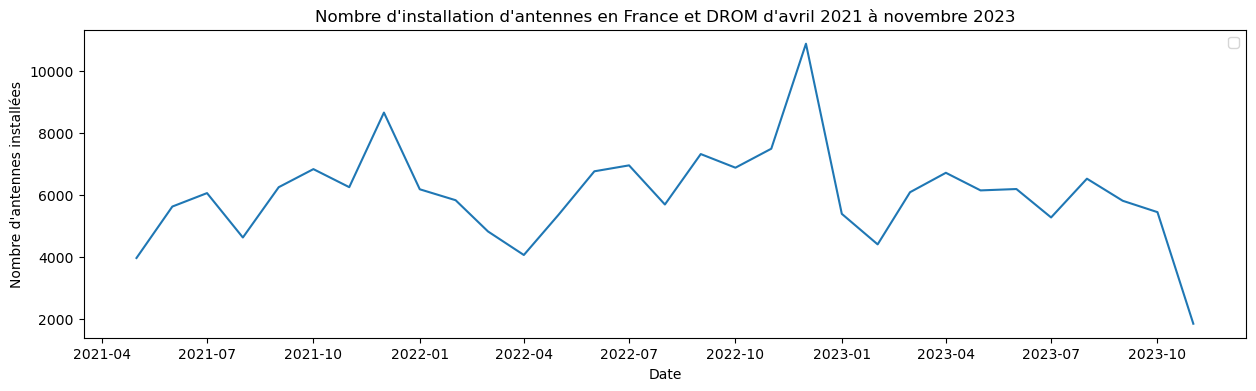

In [420]:
def plot_df(df, x, y):
    plt.figure(figsize=(15,4), dpi=100)
    plt.plot(x, y)
    plt.title("Nombre d'installation d'antennes en France et DROM d'avril 2021 à novembre 2023")
    plt.ylabel("Nombre d'antennes installées")
    plt.xlabel("Date")
    plt.legend()
    plt.show()
    
plot_df(count_days, x=count_days.index, y=count_days['count'])

#### SFR 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


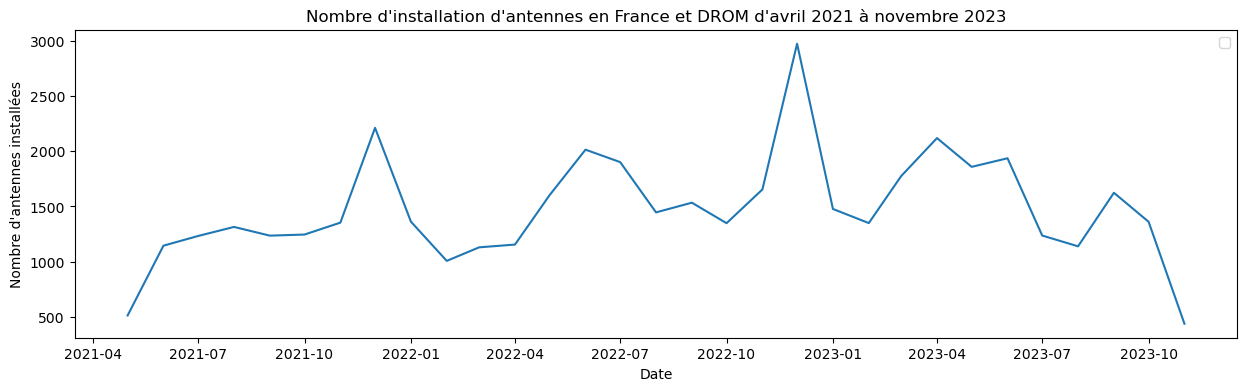

In [421]:
plot_df(count_days_sfr, x=count_days_sfr.index, y=count_days_sfr['count'])

#### Orange 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


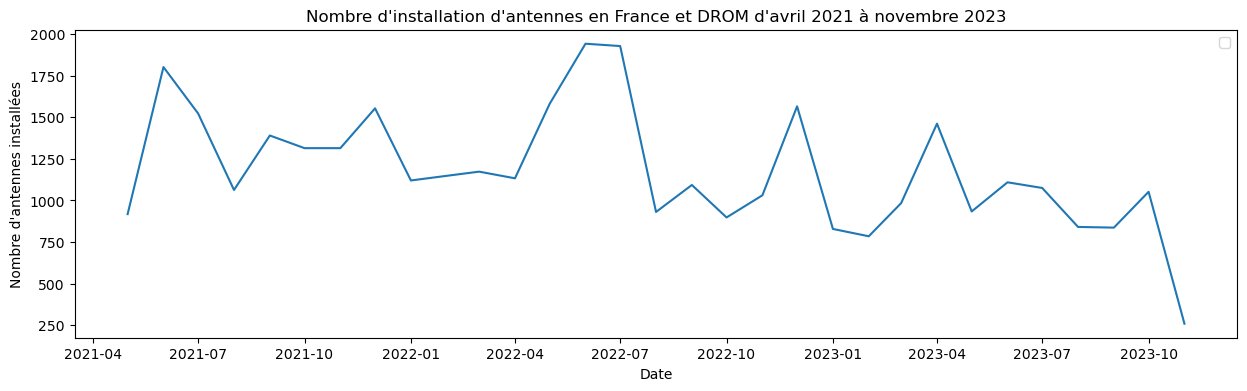

In [422]:
plot_df(count_days_orange, x=count_days_orange.index, y=count_days_orange['count'])

#### Bouygues 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


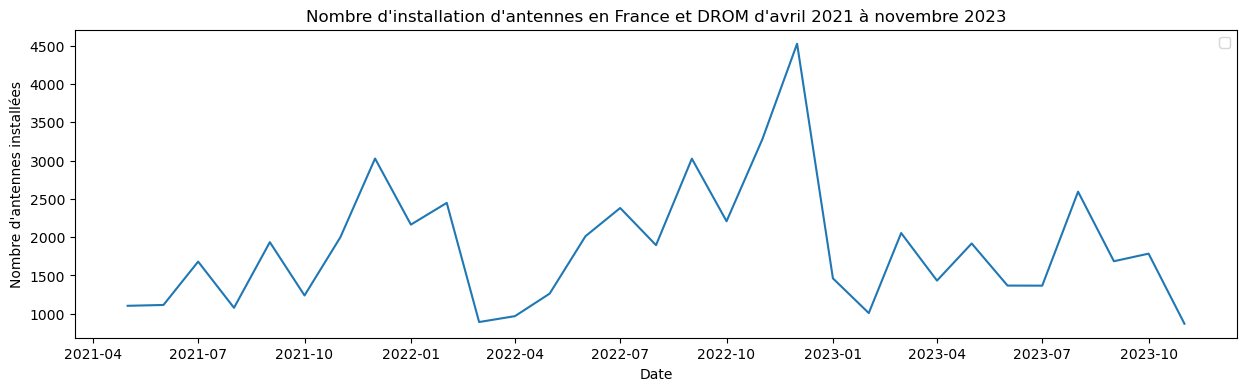

In [423]:
plot_df(count_days_bouygues, x=count_days_bouygues.index, y=count_days_bouygues['count'])

#### Free

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


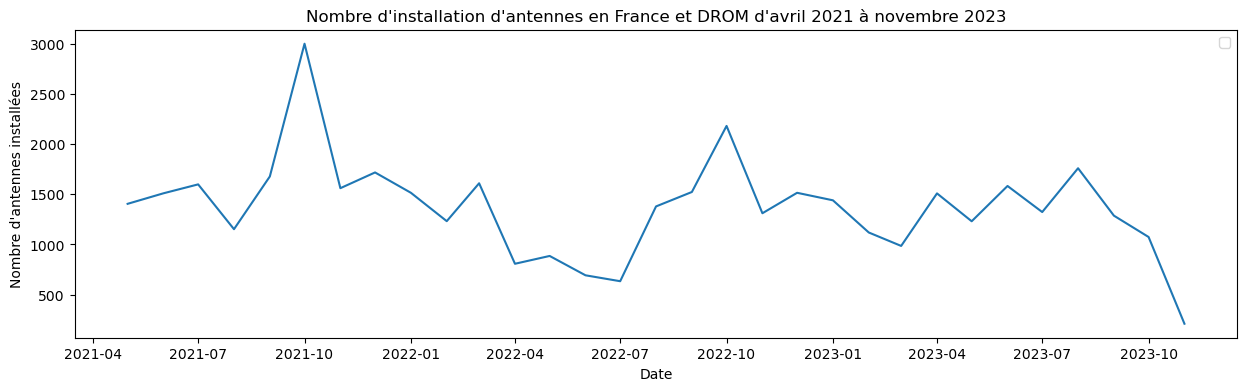

In [424]:
plot_df(count_days_free, x=count_days_free.index, y=count_days_free['count'])

# Application des modèles de prédiction et de forecast

## Modèle Prophet

In [425]:
#Ajout de la date comme index à notre Dataframe
def add_index(df_x):
    df_x["dt"] = df_x.index

In [426]:
#Application de la fonction add_index à chacun des Dataframes
add_index(count_days)
add_index(count_days_sfr)
add_index(count_days_orange)
add_index(count_days_bouygues)
add_index(count_days_free)

In [427]:
# Le modèle Prophet impose une convention de nommage des attributs, index inclus
# création de nouveaux dataframes avec les noms d'attributs convenables (ds pour la data 
# et y pour les données)
count = pd.DataFrame()
count_sfr = pd.DataFrame()
count_orange = pd.DataFrame()
count_bouygues = pd.DataFrame()
count_free = pd.DataFrame()

In [428]:
#Fonction permettant de faire la copie des donées ds Dataframes originales
#vers les Dataframes répondant aux conventions de nommage
def copy_df_new_col(df_new, df_old):
    df_new[['ds', 'y']]=df_old[['dt', 'count']].copy()
    df_new.reset_index(drop=True)

In [429]:
copy_df_new_col(count,count_days)
copy_df_new_col(count_sfr,count_days_sfr)
copy_df_new_col(count_orange,count_days_orange)
copy_df_new_col(count_bouygues,count_days_bouygues)
copy_df_new_col(count_free,count_days_free)

In [435]:
#Fonction de paramétrage du modèle Prophet
from prophet import Prophet

#Cette fonction prend en entrée le dataframe
#la période (int), dans notre cas, le nombre de jours future pour lesquelles faire la prédiction
#size = le len du dataframe pour permettre de completer le datagrame exsitant avec les nouvelles prédictions
def prophet_fit_predict(df,periods, size):
    #Instanciation
    model = Prophet()

    #La fonction fit() du modèle 
    #permet de faire l'apprentissage sur les données mis en entrée
    model.fit(df)
    
    #création d'un ouveau Dataframe dans lequel est stocké des dates antérieurs
    #aux dates sur lesquelles ont été faites l'apprentissage
    future = model.make_future_dataframe(periods=periods)
    
    #Prédiction sur les données futures = forecast
    forecast = model.predict(future)
    
    #Arrondissement des données prédites (car type float)
    forecast_prophet = forecast[['ds','yhat']].iloc[size:,:].round()
    #Pour toute donnée prédite, inféreieure à 0, 
    #la remplacer par 0
    forecast_prophet.loc[forecast_prophet['yhat'] < 0, 'yhat'] = 0
    #Faciliter l'insertion dans la base de données en faisant du Dataframe
    #une liste de valeurs
    forecast_prophet_list = forecast_prophet.values.tolist()

    #Visualisation des données originales et les données prédites
    plt.plot(forecast_prophet['ds'],forecast_prophet['yhat'])
    plt.plot(count['y'])
    plt.show()
    return forecast_prophet_list


#### Forecast général (tout opérateur confondu) 

In [431]:
#Afficher le nombre d'enregistrements du dataframe pour renseigner le 
#apramètre size
print(len(count))

31


17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing


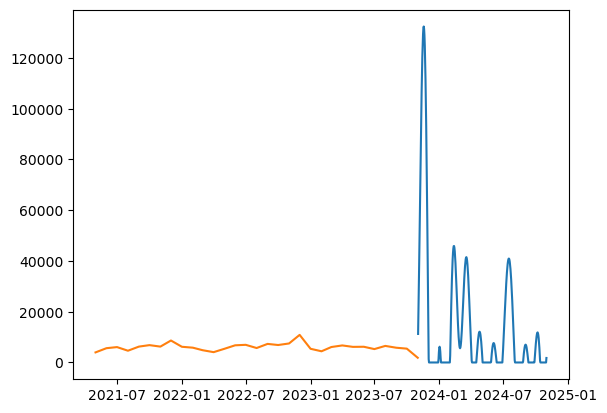

In [432]:
prophet_fit_predict = prophet_fit_predict(count,365,31)
#prophet_fit_predict_gene_list = forecast_prophet_list

#### Forecast SFR 

In [433]:
print(len(count_sfr))

31


17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing


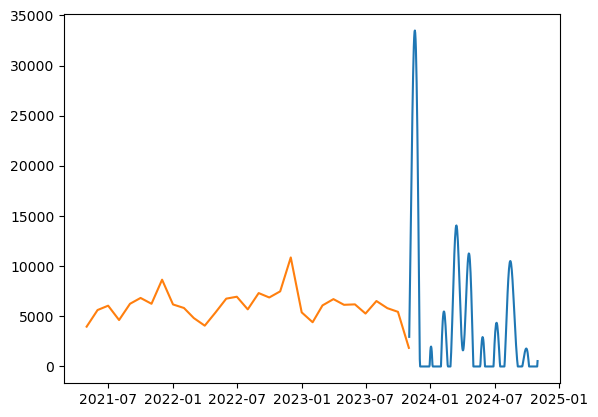

In [436]:
prophet_fit_predict_sfr = prophet_fit_predict(count_sfr,365,31)
#prophet_fit_predict_sfr_list = forecast_prophet_list

#### Forecast Bouygues 

In [96]:
print(len(count_bouygues))

31


17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing


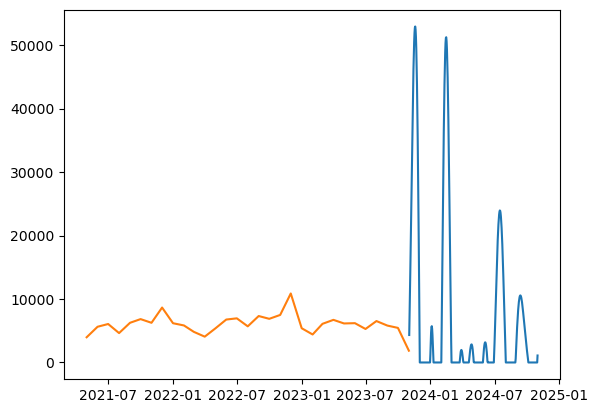

In [437]:
prophet_fit_predict_bouygues = prophet_fit_predict(count_bouygues,365,31)
#prophet_fit_predict_bouygues_list = forecast_prophet_list

#### Forecast Free 

In [99]:
print(len(count_free))

31


17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing


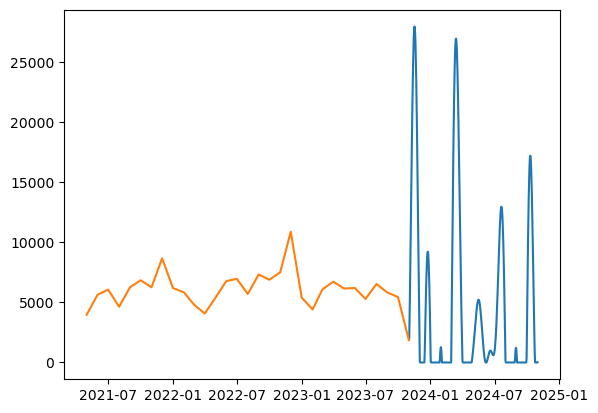

In [438]:
prophet_fit_predict_free = prophet_fit_predict(count_free,365,31)
#prophet_fit_predict_free_list = forecast_prophet_list

#### Forecast Orange 

In [101]:
print(len(count_orange))

31


17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing


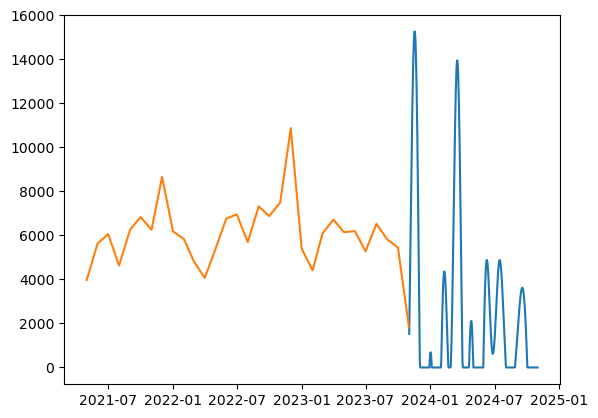

In [439]:
prophet_fit_predict_orange = prophet_fit_predict(count_orange,365,31)
#prophet_fit_predict_orange_list = forecast_prophet_list

Les prédictions avec le modèle Prophète semble sont peu représentatives de la réalité. L'apprentissage n'a pas été réussin d'ù des prédictions extravagantes. Selon la tendance générale, le nombre d'installation d'antennes devrait etre inférieur aux peaks proposés par le modèle. On parle de l'underfitting. 

La fiabilité et la performance des modèle de machine learning spécialisés dans les séries temporelles sont toujours en cours d'optimisation. 

## Modèle ARIMA

In [440]:
#Application de la fonction sur les données mensuelles
count_month = count_install_per_month(df)
count_month_sfr = count_install_per_month(df_sfr)
count_month_orange = count_install_per_month(df_orange)
count_month_bouygues = count_install_per_month(df_bouygues)
count_month_free = count_install_per_month(df_free)

C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count['m_y'] = pd.to_datetime(count['month_year'])
C:\Users\a834308\AppData\Local\Temp\ipykernel_31632\3293474906.py:6: UserWarning: 

In [441]:
#Visualisation
def viz_per_month(df):
    plt.figure(figsize= (10,6))
    plt.plot(df)
    plt.xlabel('Month-Year')
    plt.ylabel('Nombre d"antennes installées')
    plt.title('Installation des antennes en France et DROM entre Avril 2021 et Novembre 2023')

#### Forecast mensuel général 

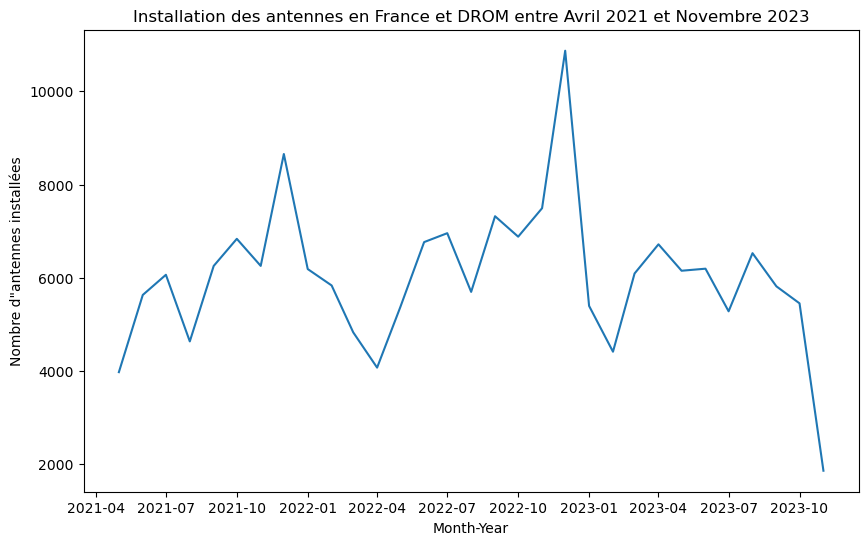

In [442]:
viz_per_month(count_month)

#### Forecast mensuel SFR 

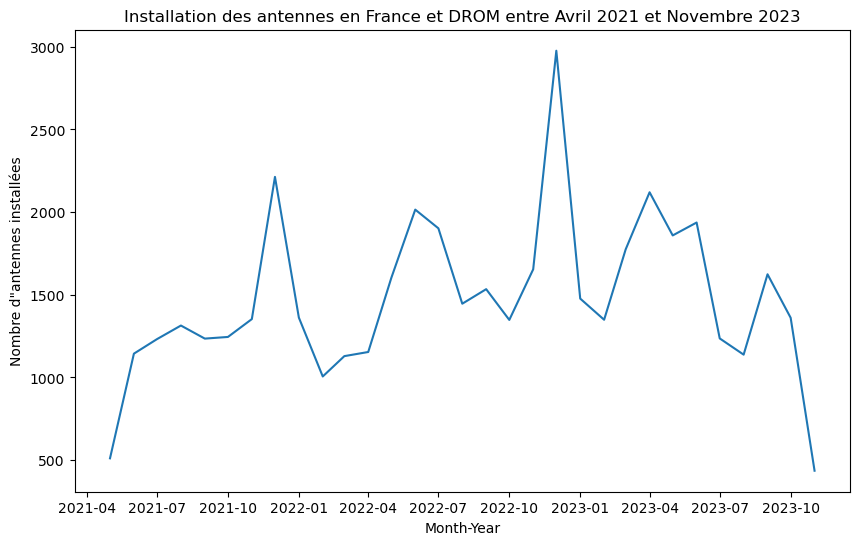

In [443]:
viz_per_month(count_month_sfr)

#### Forecast mensuel Orange 

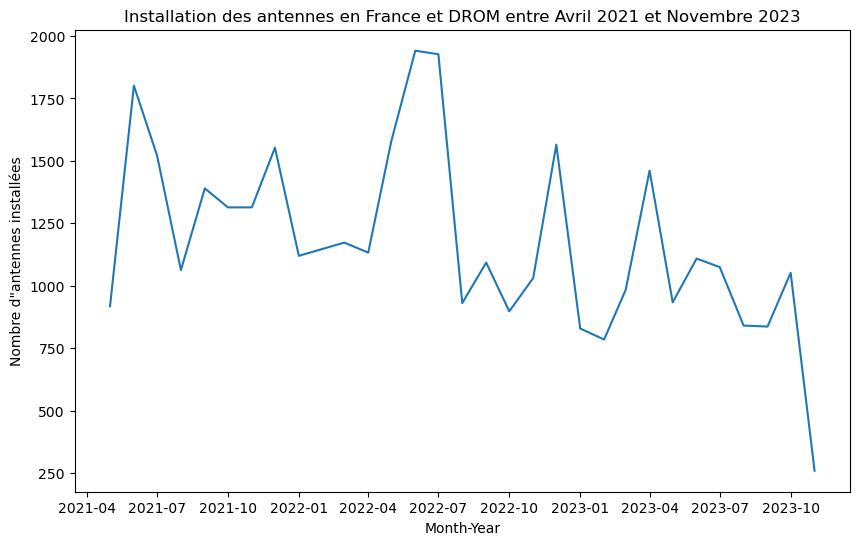

In [444]:
viz_per_month(count_month_orange)

#### Forecast mensuel Bouygues 

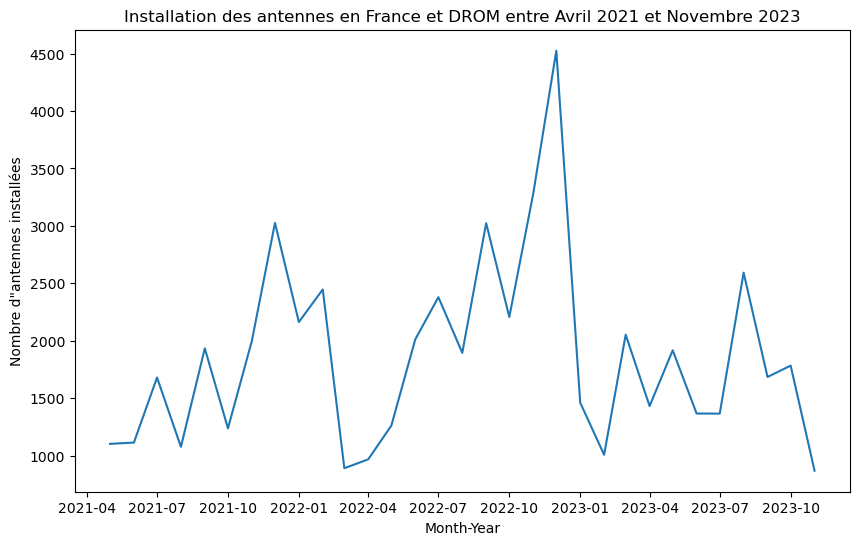

In [445]:
viz_per_month(count_month_bouygues)

#### Forecast mensuel Free 

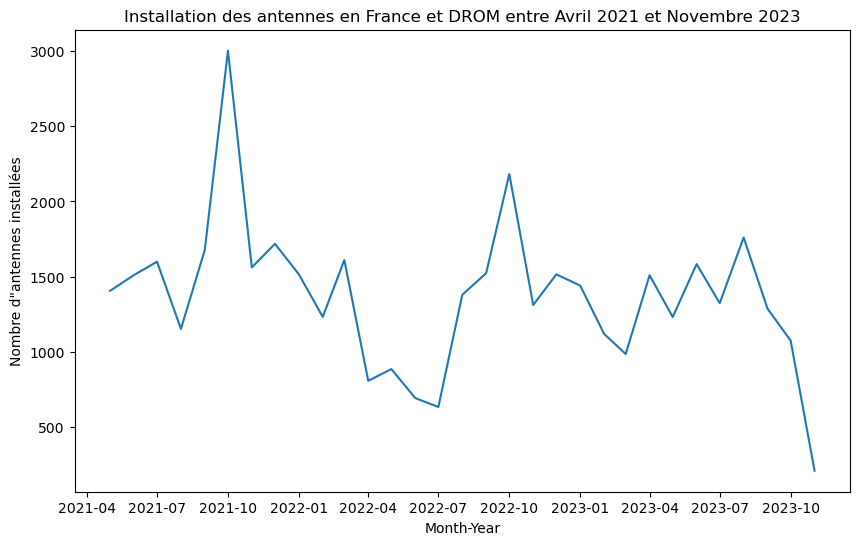

In [446]:
viz_per_month(count_month_free)

Apprentissage avec le modèle ARIMA: test avec differents paramètres avec chaucn des dataframes

In [447]:
#Premier test avec un order de 2,1,2
from statsmodels.tsa.arima.model import ARIMA

def arima_order_212(df_list):
    
    models = []
    results_ARIMA = []
    
    for df in df_list:
        model = ARIMA(df, order=(2, 1, 2), freq='MS')
        results = model.fit()
        models.append(model)
        results_ARIMA.append(results)
    return models, results_ARIMA

    df_list = [df, df1, df2, df3, df4]
    models, results_ARIMA = arima_order_212(df_list)

In [448]:
df_list = count_month, count_month_sfr, count_month_orange, count_month_bouygues, count_month_free
models, results_ARIMA = arima_order_212(df_list)

C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

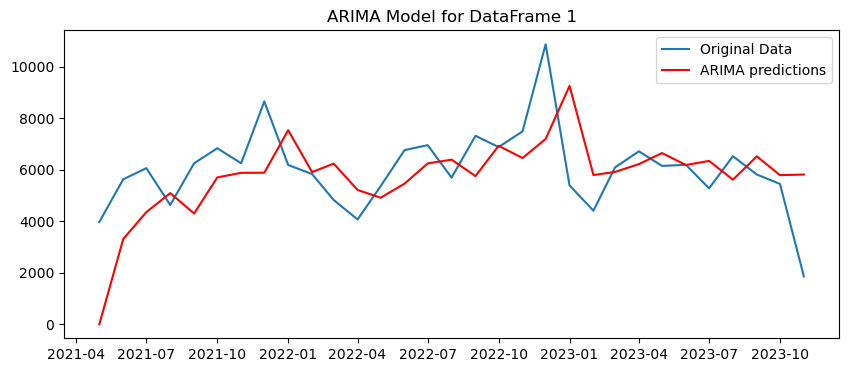

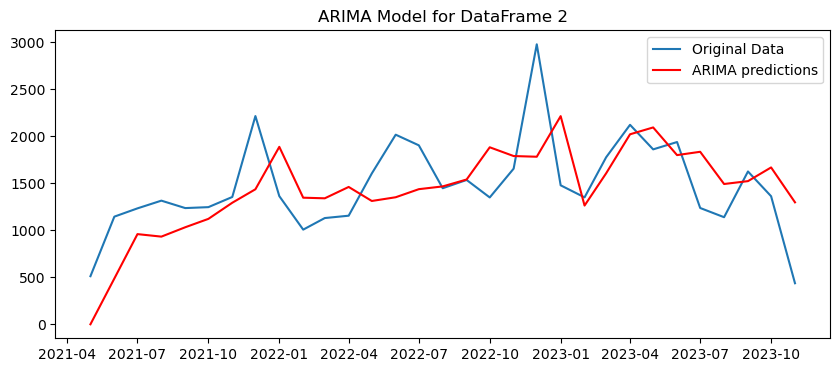

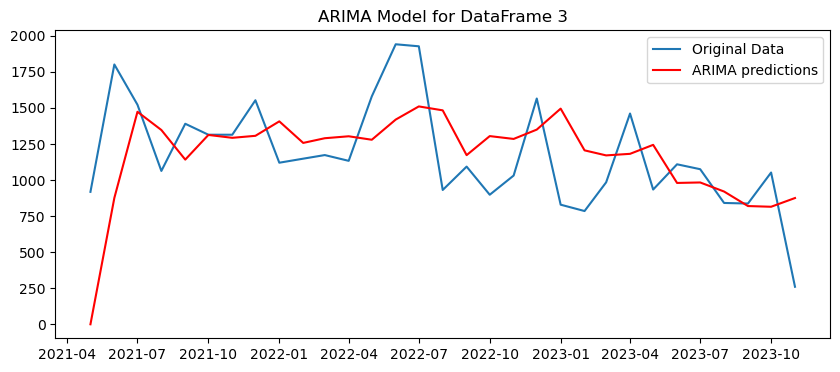

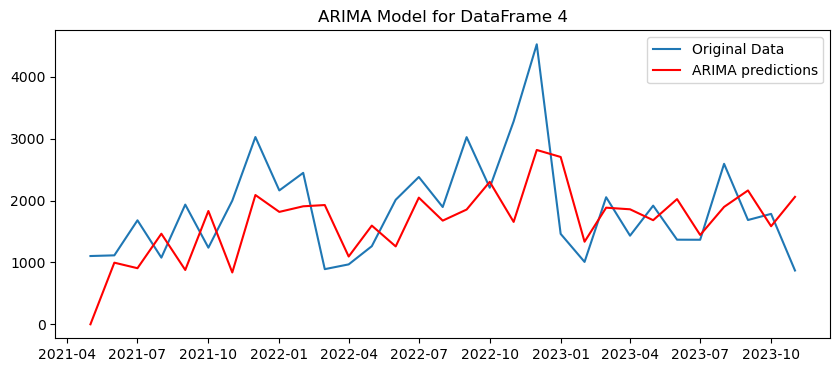

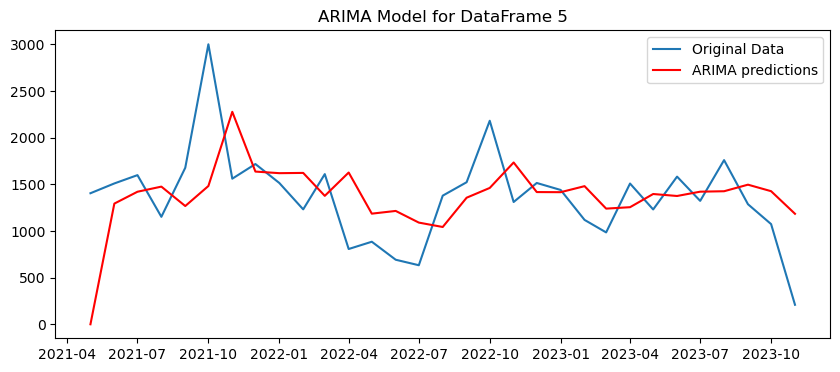

In [449]:
#Visualisation
for i, (model, results) in enumerate(zip(models, results_ARIMA)):
    plt.figure(figsize=(10, 4))
    # Replace 'your_data_column_name' with the appropriate column name from your DataFrame
    plt.plot(df_list[i]['count'], label='Original Data')
    plt.plot(results.fittedvalues, color='red', label='ARIMA predictions')
    plt.title(f'ARIMA Model for DataFrame {i+1}')
    plt.legend()
    plt.show()

In [450]:
#Premier test avec un order de 2,1,2
from statsmodels.tsa.arima.model import ARIMA

def arima_order_210(df_list):
    
    models = []
    results_ARIMA = []
    
    for df in df_list:
        model = ARIMA(df, order=(2, 1, 0), freq='MS')
        results = model.fit()
        models.append(model)
        results_ARIMA.append(results)
    return models, results_ARIMA

    df_list = [df, df1, df2, df3, df4]
    models, results_ARIMA = arima_order_212(df_list)

In [451]:
models, results_ARIMA = arima_order_210(df_list)

C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\a834308\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: 

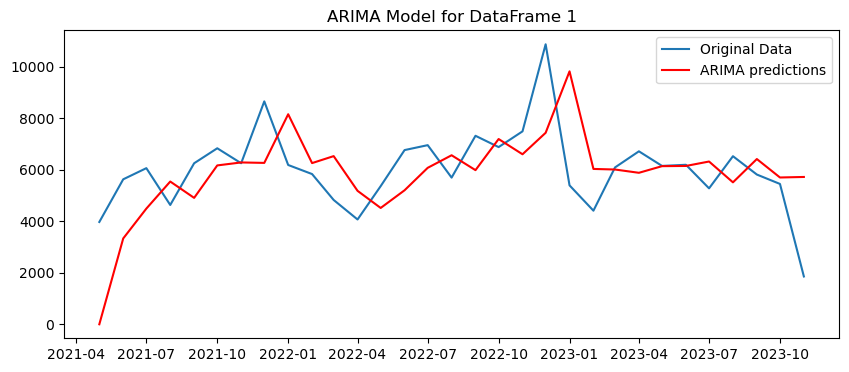

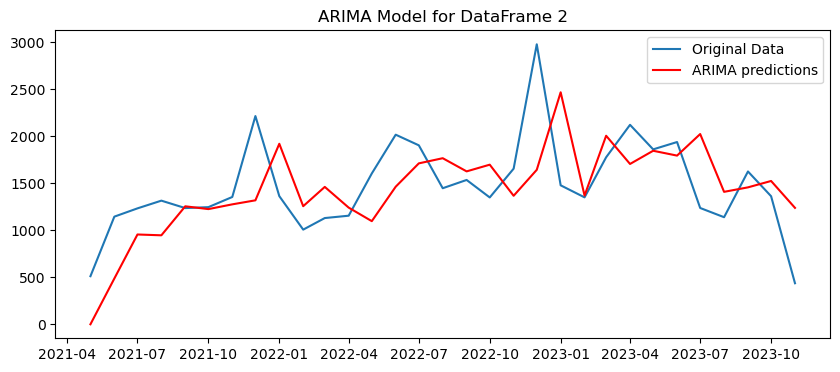

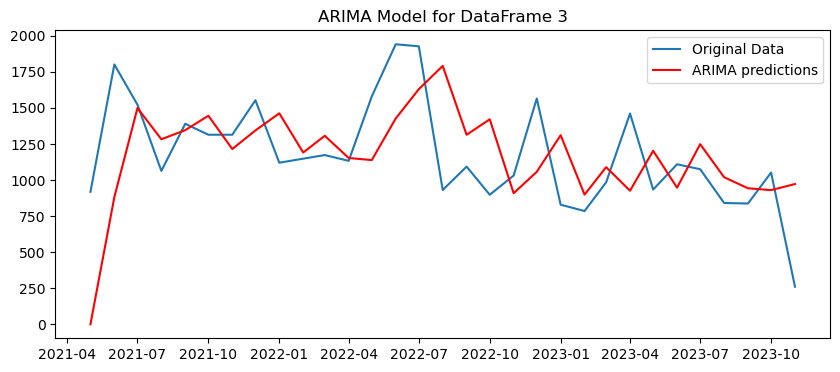

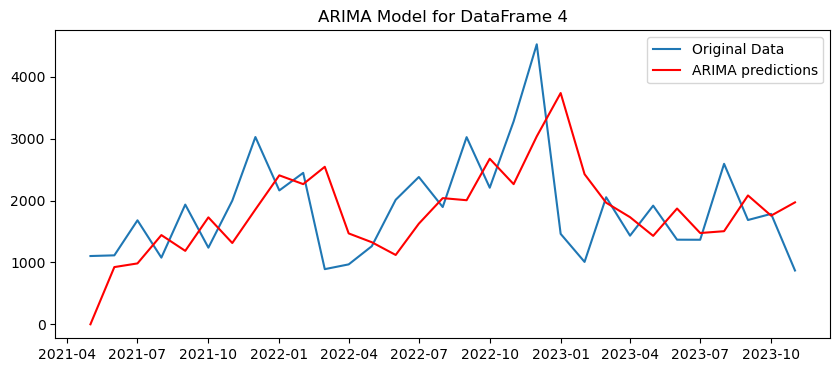

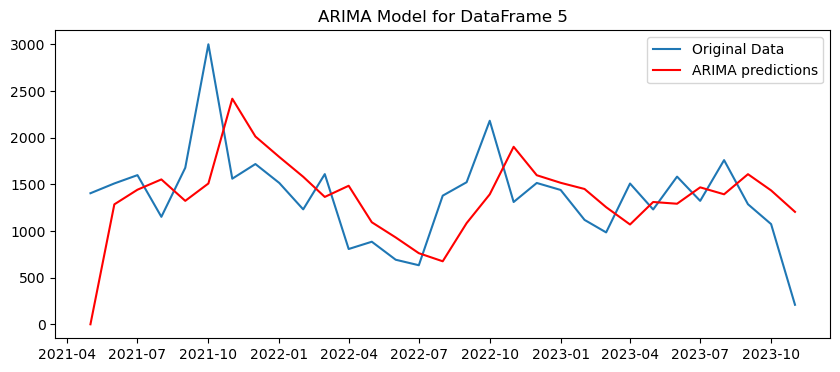

In [452]:
#Visualisation
for i, (model, results) in enumerate(zip(models, results_ARIMA)):
    plt.figure(figsize=(10, 4))
    # Replace 'your_data_column_name' with the appropriate column name from your DataFrame
    plt.plot(df_list[i]['count'], label='Original Data')
    plt.plot(results.fittedvalues, color='red', label='ARIMA predictions')
    plt.title(f'ARIMA Model for DataFrame {i+1}')
    plt.legend()
    plt.show()

Le modèle ARIMA avec le paramètre Order 2,1,0 semble etre le plus optimale car l'apprentissage est le plus correct indépendameent des datasets sur lesquels sont faits les appprentissages

In [453]:
#Stocker dans des variables, les données prédites
result1, result2, result3, result4, result5 = results_ARIMA
result1 = results_ARIMA[0]
result2 = results_ARIMA[1]
result3 = results_ARIMA[2]
result4 = results_ARIMA[3]
result5 = results_ARIMA[4]

In [454]:
#predictions
def forecasting_year(result):
    df_x = result.forecast(steps=12)
    return df_x

In [455]:
#Application de la fonction de forecast
general = forecasting_year(result1).astype(int)
sfr = forecasting_year(result2).astype(int)
orange = forecasting_year(result3).astype(int)
bouygues = forecasting_year(result4).astype(int)
free = forecasting_year(result5).astype(int)

In [456]:
#visualisation
def plot_arima_forecast(forecast, original):
    plt.plot(forecast, label="Forecasted")
    plt.plot(original, label="Original")
    plt.xlabel("Month-Year")
    plt.ylabel("Nombre d'antennes installées")
    plt.legend()
    plt.show()

#### Forecast général 

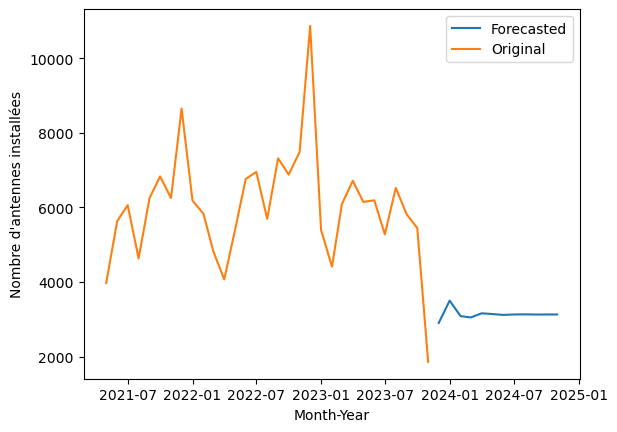

In [457]:
plot_arima_forecast(general,count_month)

#### Forecast SFR 

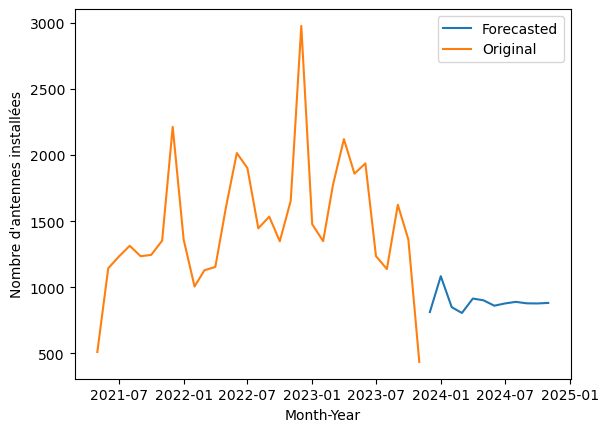

In [458]:
plot_arima_forecast(sfr,count_month_sfr)

#### Forecast Orange 

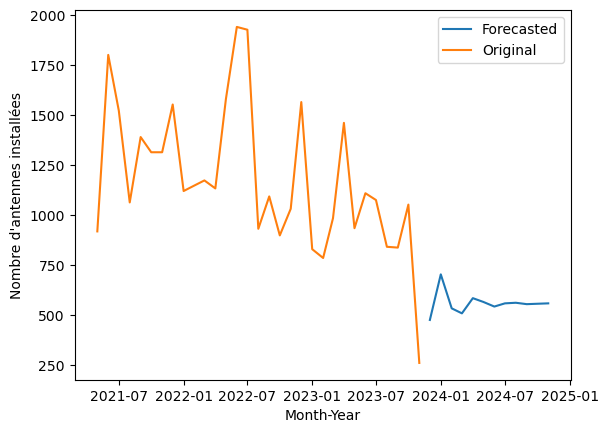

In [459]:
plot_arima_forecast(orange, count_month_orange)

#### Forecast Bouygues 

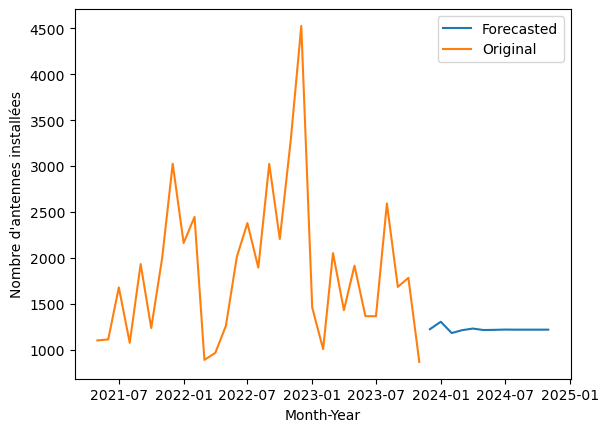

In [460]:
plot_arima_forecast(bouygues, count_month_bouygues)

#### Forecast Free

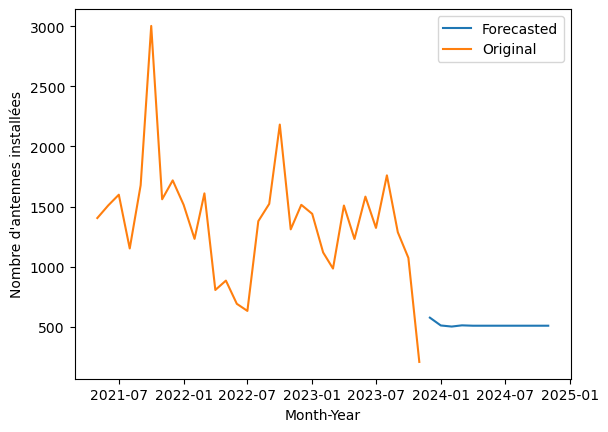

In [461]:
plot_arima_forecast(free, count_month_free )

Similairement au modèle Prophet, les prédictions représentent peu la réalité. Cependant, ces dernières sont plus cohérentes que celle du modèle précédent. Faute de temps, nous ne pouvons pas chercher les hyperparamètres permettant de faire les meilleures apprentissages et prédictions.

# LSTM

In [463]:
#Import des librairies 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [464]:
#Standardisation des données
df_sfr = count_month.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
df_sfr = scaler.fit_transform(df_sfr)
df_sfr

array([[0.23469388],
       [0.41847825],
       [0.46650398],
       [0.3078971 ],
       [0.48757768],
       [0.55212957],
       [0.48768854],
       [0.75410384],
       [0.4801464 ],
       [0.4411047 ],
       [0.3295253 ],
       [0.24545252],
       [0.38908607],
       [0.5443656 ],
       [0.56555015],
       [0.4257986 ],
       [0.6059228 ],
       [0.5572316 ],
       [0.625     ],
       [1.        ],
       [0.3924135 ],
       [0.2833851 ],
       [0.46960962],
       [0.5390417 ],
       [0.4761535 ],
       [0.48103374],
       [0.37954748],
       [0.51796806],
       [0.43899733],
       [0.39851373],
       [0.        ]], dtype=float32)

In [465]:
# split notre dataset en test et aprpentissage
train_size = int(len(df_sfr) * 0.8)
test_size = len(df_sfr) - train_size
train, test = df_sfr[0:train_size,:], df_sfr[train_size:len(df_sfr),:]
print(len(train), len(test))

24 7


In [466]:
# convertir un tableau de valeurs en une matrice d'ensemble de données
def create_dataset(df, look_back=1):
	X, Y = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		X.append(a)
		Y.append(df[i + look_back, 0])
	return np.array(X), np.array(Y)

In [470]:
# reshape les données
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [471]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [472]:
# Creation et apprentissage avec le modèle LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
22/22 - 2s - loss: 0.2290 - 2s/epoch - 107ms/step
Epoch 2/100
22/22 - 0s - loss: 0.1875 - 49ms/epoch - 2ms/step
Epoch 3/100
22/22 - 0s - loss: 0.1519 - 60ms/epoch - 3ms/step
Epoch 4/100
22/22 - 0s - loss: 0.1231 - 44ms/epoch - 2ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0984 - 60ms/epoch - 3ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0796 - 57ms/epoch - 3ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0634 - 60ms/epoch - 3ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0521 - 61ms/epoch - 3ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0426 - 55ms/epoch - 2ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0365 - 52ms/epoch - 2ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0319 - 53ms/epoch - 2ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0294 - 57ms/epoch - 3ms/step
Epoch 13/100
22/22 - 0s - loss: 0.0272 - 62ms/epoch - 3ms/step
Epoch 14/100
22/22 - 0s - loss: 0.0266 - 52ms/epoch - 2ms/step
Epoch 15/100
22/22 - 0s - loss: 0.0256 - 49ms/epoch - 2ms/step
Epoch 16/100
22/22 - 0s - loss: 0.0253 - 49ms/epoch - 2ms/step
E

In [473]:
# Predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverser les prédictions étant donné que les données ont été normalisées
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

# Calcul de l'erreur lors de d'apprentissage
trainScore = np.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 32ms/step
Train Score: 1410.06 RMSE
Test Score: 665.40 RMSE


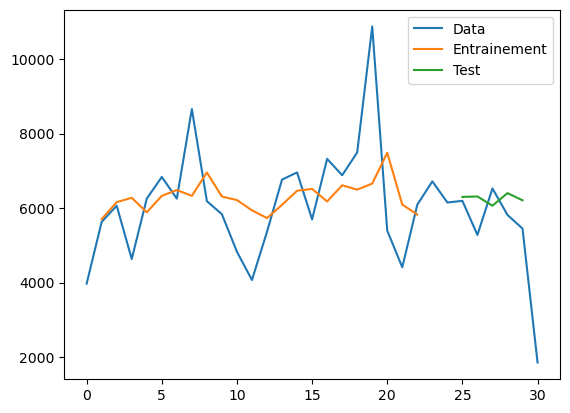

In [474]:
# Visualisation
trainPredictPlot = np.empty_like(df_sfr)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


testPredictPlot = np.empty_like(df_sfr)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_sfr)-1, :] = testPredict

plt.plot(scaler.inverse_transform(df_sfr), label="Data")
plt.plot(trainPredictPlot, label="Entrainement")
plt.plot(testPredictPlot, label="Test")
plt.legend()
plt.show()

L'apprentissage est plus ou moins réussie. Encore une fois, faute de temps, nous nous arretons à ce niveau. Bin sur, il aurait été possible d'améliorer l'apprentissage et de faire des prédictions.

Dans nos tableaux de bord, nous prévoyons d'intégrer les données prédites par ARIMA. Cela est motivé par une question de temps (faute de temps pour chercher les hyperparamètres) et par la cohérence des données par rapport à la réalité.

## Enregistrement des données dans la BD cible PostgreSQL 

In [475]:
#Tranformation des données prédites sous forme de liste
#pour faciliter l'insertion dans la BD
def to_list(df):
    df = df.to_frame()
    df['dt'] = df.index
    df = df.reset_index()
    df= df.drop('dt', axis=1)
    df= df.drop(index=df.index[-1],axis=0)
    df_list = df.values.tolist()
    return df_list

In [476]:
#application de la fonction précédente
general_list = to_list(general)
sfr_list = to_list(sfr)
orange_list = to_list(orange)
bouygues_list = to_list(bouygues)
free_list = to_list(free)

In [479]:
#Fonction permettant d'inserer les données dans la BD
#en prenant en paramètres la liste de données
# et la requete d'insertion
def insert_into_postgres(liste, query):
    cur = conn.cursor()
    try:
    # Faire une insertion pour chaque enregistrement de la liste
        for i in liste:
            cur.execute(query, i)
            conn.commit()
        print("Données enregistrées")
    except(Exception, psycopg2.Error) as error:
        print("Erreur, les données n'ont pas été insérées: ", error)


In [480]:
# Requetes d'insertion des données dans la BD
query_general = "INSERT INTO  public.predictions_ARIMA(dt, count_antennas) VALUES (%s, %s)"
query_sfr = "INSERT INTO  public.predictions_ARIMA_sfr(dt, count_antennas) VALUES (%s, %s)"
query_orange = "INSERT INTO  public.predictions_ARIMA_orange(dt, count_antennas) VALUES (%s, %s)"
query_bouygues = "INSERT INTO  public.predictions_ARIMA_bouygues(dt, count_antennas) VALUES (%s, %s)"
query_free = "INSERT INTO  public.predictions_ARIMA_free(dt, count_antennas) VALUES (%s, %s)"

In [481]:
#Application de la fonction d'insertion
insert_into_postgres(general_list, query_general)
insert_into_postgres(sfr_list, query_sfr)
insert_into_postgres(orange_list, query_orange)
insert_into_postgres(bouygues_list, query_bouygues)
insert_into_postgres(free_list, query_free)

Données enregistrées
Données enregistrées
Données enregistrées
Données enregistrées
Données enregistrées


In [482]:
#fermeture de la connexion à la base de données
cur.close()
conn.close()